In [1]:
import cv2
import os
import random
import numpy as np
from PIL import Image
import tensorflow as tf
import matplotlib.pyplot as plt

2024-05-06 08:48:14.355765: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-06 08:48:14.355870: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-06 08:48:14.479234: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
lr_image_dir="/kaggle/input/miniproj/div2k/Validation/LR/lr_images"
hr_image_dir="/kaggle/input/miniproj/div2k/Validation/HR/hr_images"

# Image super resolution by simple interpolation - Nearest neighbor & Bilinear

In [3]:
os.mkdir("Interpolated images")
os.mkdir("Interpolated images1")

# SSIM and PSNR metrics

In [4]:
def ssim_metric(y_true, y_pred):
    # Convert images to float32 if necessary and scale them to [0, 1]
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    
    # Compute SSIM index for each image
    ssim_index_per_image = tf.image.ssim(y_true, y_pred, max_val=1.0)
    
    # Compute mean SSIM index across all images in the batch
    mean_ssim_index = tf.reduce_mean(ssim_index_per_image)
    
    return mean_ssim_index
def psnr_metric(y_true, y_pred):
    # Convert images to float32 if necessary and scale them to [0, 1]
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    
    # Compute MSE between true and predicted images
    mse = tf.reduce_mean(tf.square(y_true - y_pred))
    
    # Compute PSNR using the formula: PSNR = 20 * log10(max_pixel) - 10 * log10(MSE)
    max_pixel = 1.0  # Assuming images are normalized to [0, 1] range
    psnr = 20 * tf.math.log(max_pixel) / tf.math.log(10.0) - 10 * tf.math.log(mse) / tf.math.log(10.0)
    
    return psnr

# Interpolating, calculating metrics and storing results

In [5]:
def interpolate_NN(path,highrespath):
    scores=[]
    psnr_score=[]
    ssim_score=[]
    j=0
    imgs=[]
    for i in os.listdir(path):
        low_res_image=cv2.imread(path+"/"+i,cv2.IMREAD_COLOR)[...,::-1]/255.0
        original_image=cv2.resize(cv2.imread(highrespath+"/"+i,cv2.IMREAD_COLOR),(2040,2040),interpolation=cv2.INTER_CUBIC)[...,::-1]/255.0
        high_res_image = cv2.resize(low_res_image, (2040,2040), interpolation=cv2.INTER_NEAREST)   
        score= np.mean((original_image - high_res_image/255.0) ** 2)
        i1=tf.convert_to_tensor(np.array(original_image))
        i2=tf.convert_to_tensor(np.array(high_res_image/255.0))
        psnr_score.append(psnr_metric(i1,i2).numpy())
        ssim_score.append(ssim_metric(i1,i2).numpy())
        scores.append(score)
        if(j<35):
            imgs.append([low_res_image,high_res_image,original_image])
        j+=1    
    print("Average MSE for Nearest neighbor:",sum(scores)/len(scores))
    print("Average PSNR for Nearest neighbor:",sum(psnr_score)/len(scores))
    print("Average SSIM for Nearest neighbor:",sum(ssim_score)/len(scores))
    return imgs


In [6]:
def interpolate_bilinear(path,highrespath):
    scores=[]
    psnr_score=[]
    ssim_score=[]
    j=0
    imgs=[]
    for i in os.listdir(path):
        low_res_image=cv2.imread(path+"/"+i,cv2.IMREAD_COLOR)[...,::-1]/255.0
        original_image=cv2.resize(cv2.imread(highrespath+"/"+i,cv2.IMREAD_COLOR),(2040,2040),interpolation=cv2.INTER_CUBIC)[...,::-1]/255.0
        high_res_image = cv2.resize(low_res_image, (2040,2040), interpolation=cv2.INTER_LINEAR)
        score= np.mean((original_image - high_res_image/255.0) ** 2)
        i1=tf.convert_to_tensor(np.array(original_image))
        i2=tf.convert_to_tensor(np.array(high_res_image/255.0))
        psnr_score.append(psnr_metric(i1,i2).numpy())
        ssim_score.append(ssim_metric(i1,i2).numpy())
        scores.append(score)
        if(j<35):
            imgs.append([low_res_image,high_res_image,original_image])
        j+=1
    print("Average MSE for Bilinear:",sum(scores)/len(scores))
    print("Average PSNR for Bilinear:",sum(psnr_score)/len(scores))
    print("Average SSIM for Bilinear:",sum(ssim_score)/len(scores))
    return imgs



In [7]:
images=interpolate_NN(lr_image_dir,hr_image_dir)
images1=interpolate_bilinear(lr_image_dir,hr_image_dir)

Average MSE for Nearest neighbor: 0.17666872416442855
Average PSNR for Nearest neighbor: 8.281061481027042
Average SSIM for Nearest neighbor: 0.33000631015017334
Average MSE for Bilinear: 0.17667133873157698
Average PSNR for Bilinear: 8.280975178176282
Average SSIM for Bilinear: 0.3300213209152514


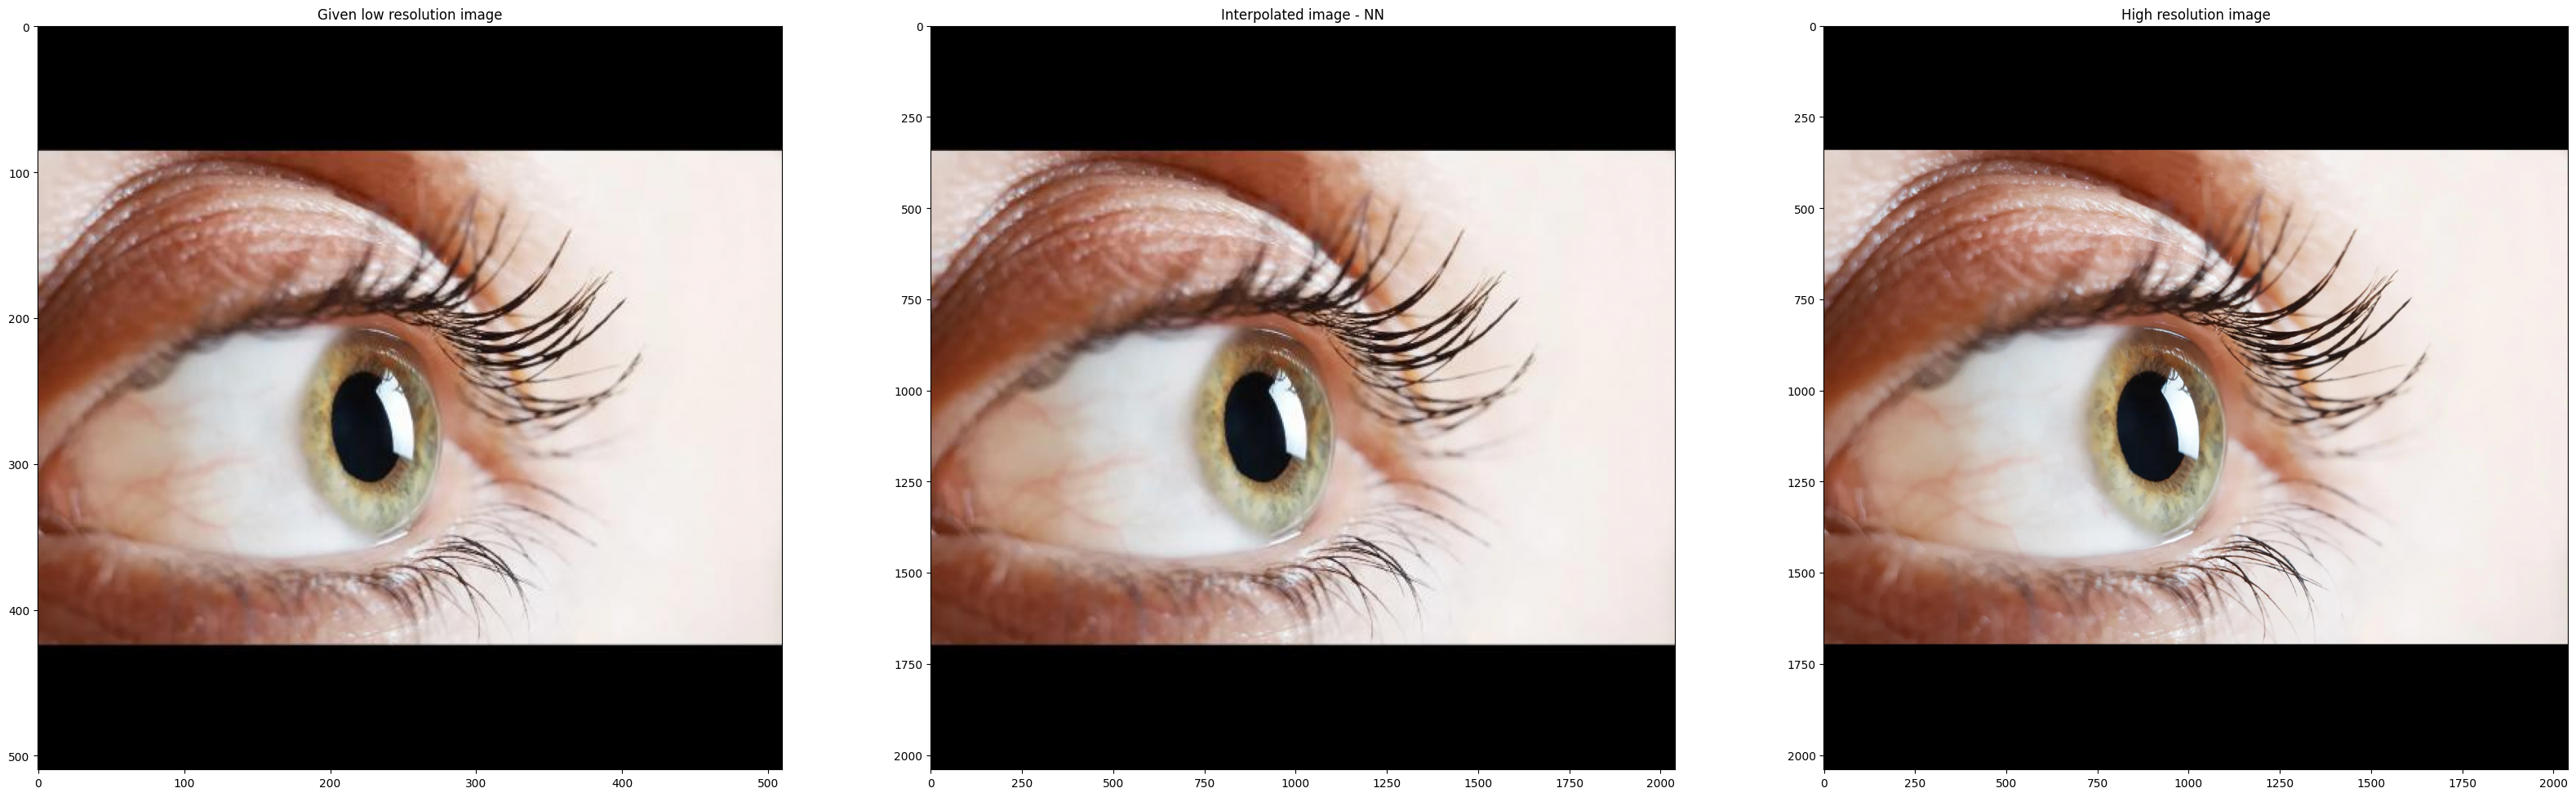

In [8]:
img1,img2,img3=images[-1]
plt.figure(figsize=(40,20))
plt.subplot(1, 3, 1)
plt.imshow(img1)
plt.title('Given low resolution image')
plt.subplot(1, 3, 2)
plt.imshow(img2)
plt.title('Interpolated image - NN')
plt.subplot(1, 3, 3)
plt.imshow(img3)
plt.title('High resolution image')
plt.show()

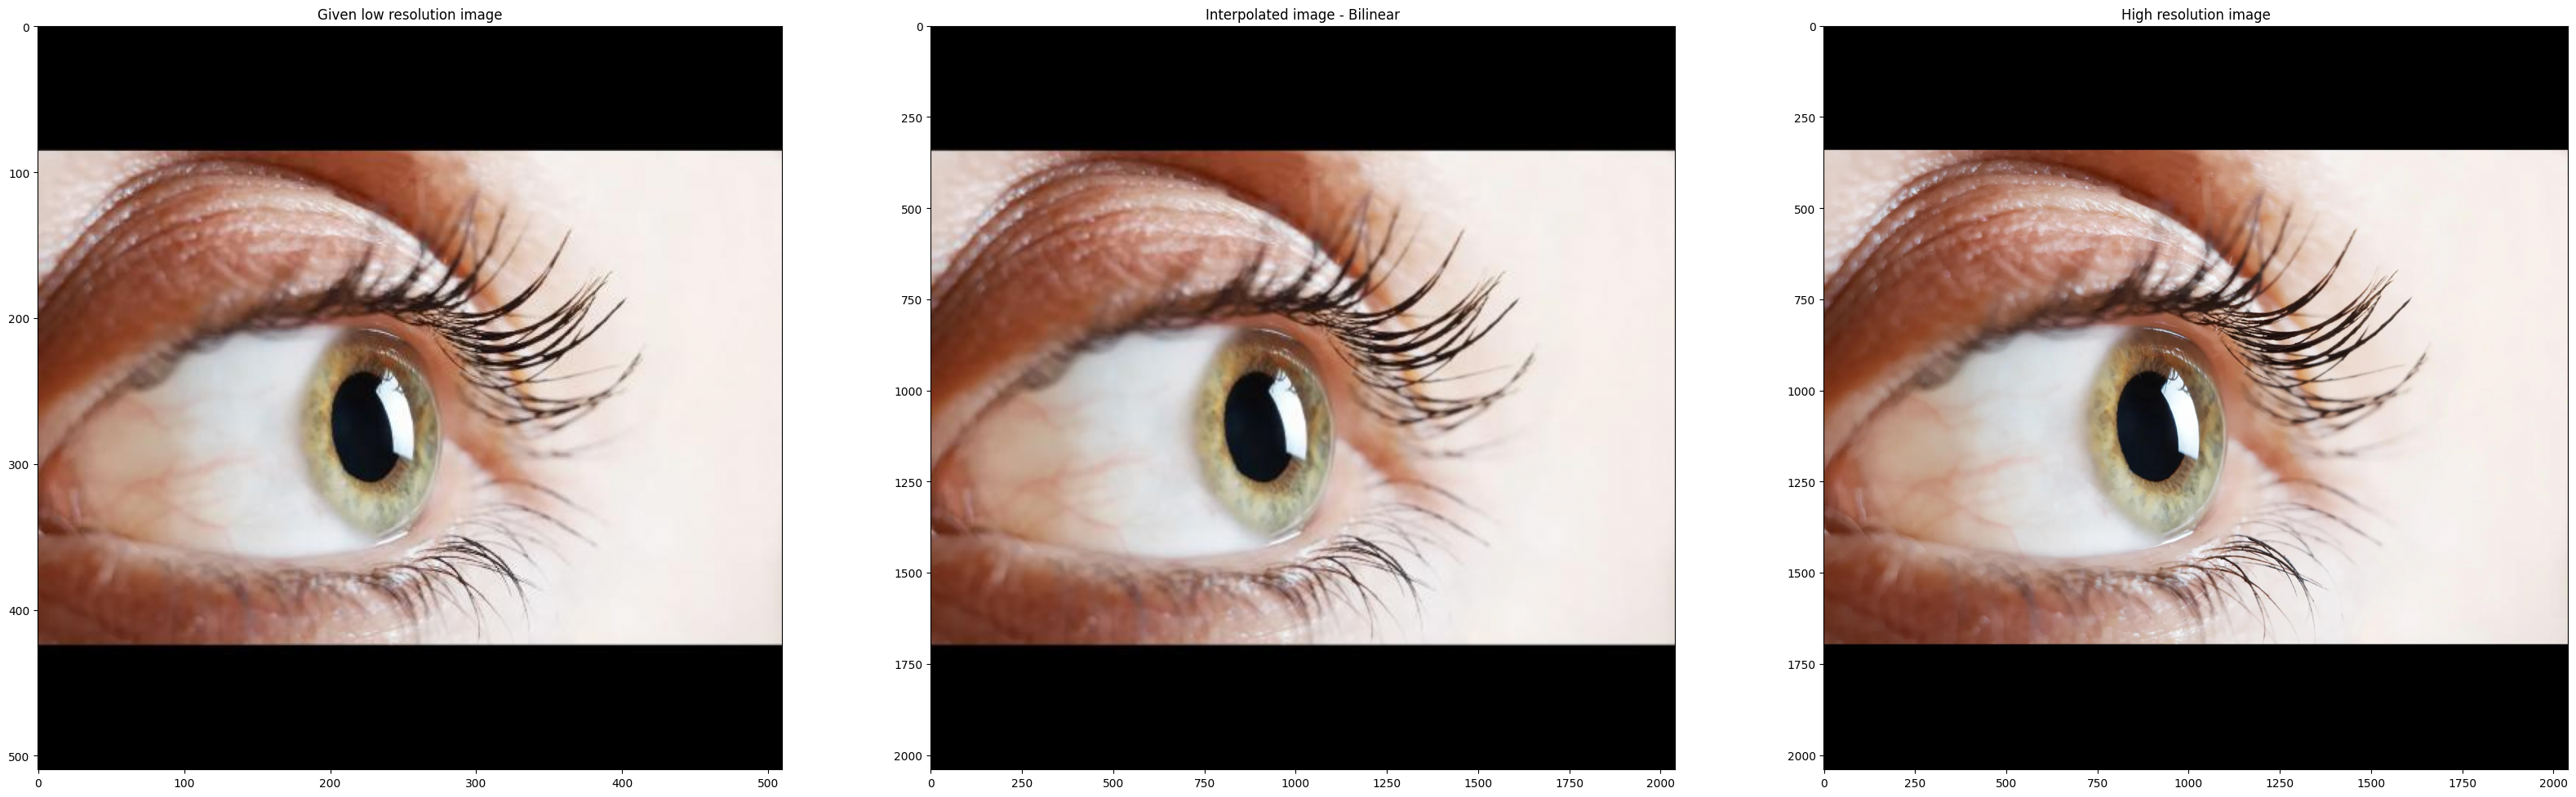

In [9]:
img1,img2,img3=images1[-1]
plt.figure(figsize=(40,20))
plt.subplot(1, 3, 1)
plt.imshow(img1)
plt.title('Given low resolution image')
plt.subplot(1, 3, 2)
plt.imshow(img2)
plt.title('Interpolated image - Bilinear')
plt.subplot(1, 3, 3)
plt.imshow(img3)
plt.title('High resolution image')
plt.show()